In [34]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import Adam
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms.functional import resized_crop
import torchvision.models as models
from torchvision.io import decode_png
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd 

import torchsummary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [3]:
pre_trained = models.mobilenet_v3_large(weights="MobileNet_V3_Large_Weights.IMAGENET1K_V1")

In [4]:
print(pre_trained)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [5]:
torchsummary.summary(pre_trained, (3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 960, 8, 8]           --
|    └─Conv2dNormActivation: 2-1                   [-1, 16, 128, 128]        --
|    |    └─Conv2d: 3-1                            [-1, 16, 128, 128]        432
|    |    └─BatchNorm2d: 3-2                       [-1, 16, 128, 128]        32
|    |    └─Hardswish: 3-3                         [-1, 16, 128, 128]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 128, 128]        --
|    |    └─Sequential: 3-4                        [-1, 16, 128, 128]        464
|    └─InvertedResidual: 2-3                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-5                        [-1, 24, 64, 64]          3,440
|    └─InvertedResidual: 2-4                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-6                        [-1, 24, 64, 64]          4,440
|    └─InvertedResidual: 2-

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 960, 8, 8]           --
|    └─Conv2dNormActivation: 2-1                   [-1, 16, 128, 128]        --
|    |    └─Conv2d: 3-1                            [-1, 16, 128, 128]        432
|    |    └─BatchNorm2d: 3-2                       [-1, 16, 128, 128]        32
|    |    └─Hardswish: 3-3                         [-1, 16, 128, 128]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 128, 128]        --
|    |    └─Sequential: 3-4                        [-1, 16, 128, 128]        464
|    └─InvertedResidual: 2-3                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-5                        [-1, 24, 64, 64]          3,440
|    └─InvertedResidual: 2-4                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-6                        [-1, 24, 64, 64]          4,440
|    └─InvertedResidual: 2-

In [10]:
df = pd.read_csv("./data/labels.csv")
breeds = df.breed.unique()
map = {} 
for i, breed in enumerate(breeds):
    map[breed] = i

def get_dim(img, target_dim):
    channels, height, width = img.size()
    if height <= width: 
        new_height = target_dim
        new_width = int(width * target_dim / height)
    else: 
        new_width = target_dim
        new_height = int(height * target_dim / width)
    return new_height, new_width

In [7]:
class CustomDataset(Dataset): 
    def __init__(self, csv_file, base_dir, map, size=256): 
        self.annotations = pd.read_csv(csv_file)
        self.base_path = base_dir
        self.map = map
        self.size = size
    
    def __len__(self): 
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = self.base_path + "/" + self.annotations.iloc[index, 0] + ".jpg"
        image = read_image(img_path)
        image = T.Resize((self.size, self.size))(image)
        y_label = self.map[self.annotations.iloc[index, 1]]
        return (image, y_label)


In [8]:
dataset = CustomDataset(
    csv_file="./data/labels.csv",
    base_dir="./data/train",
    map=map, 
    )

print(len(map))

120


In [9]:
# split to train and test
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

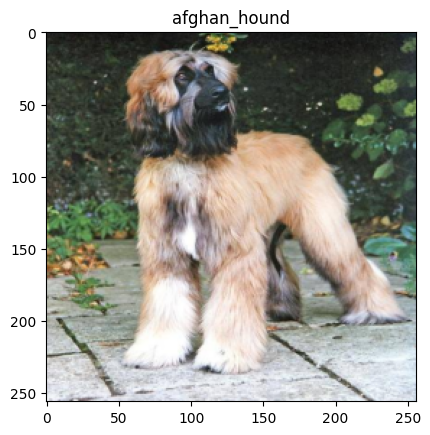

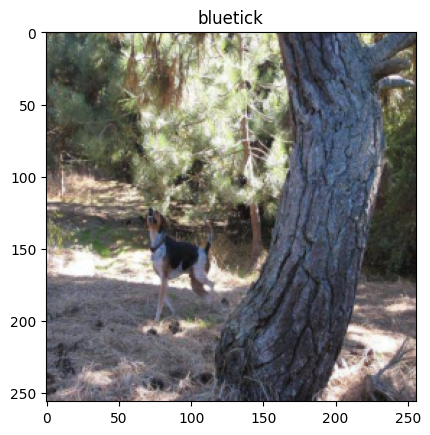

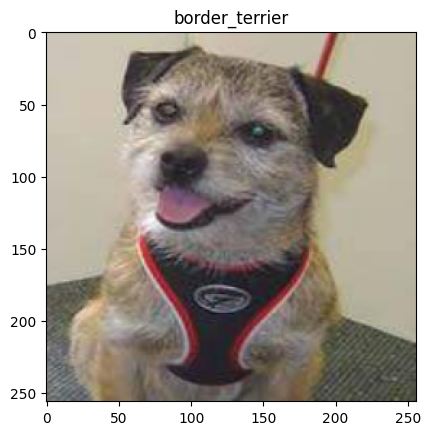

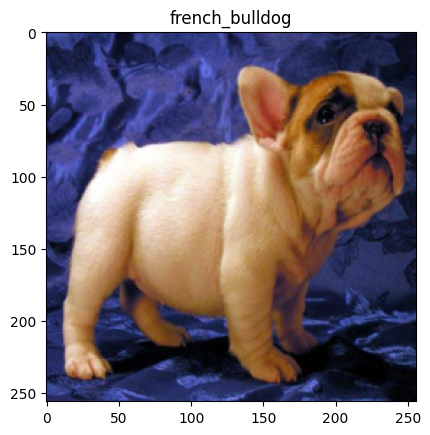

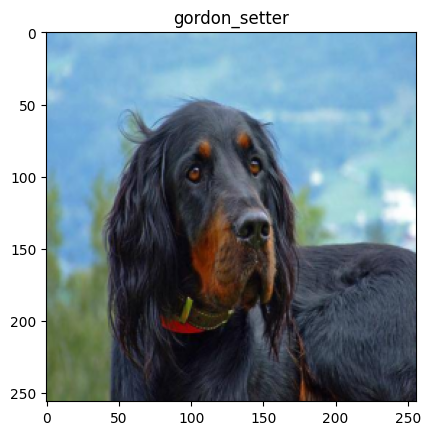

In [11]:
# see some training data
for i in range(5): 
    img, label = train_dataset[i]
    plt.imshow(img.permute(1, 2, 0))
    plt.title(breeds[label])
    plt.show()

In [5]:
img_width = 256
img_height = 256

class Augmented(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        # load all images into memory
        self.images = []
        self.labels = []
        self.custom_transforms = [self.apply_gray, self.flipped, self.original, self.colour_jitter]
        self.load_to_memory()

    def load_to_memory(self):
        for i in range(len(self.dataset)):
            img, label = self.dataset[i]
            for transform in self.custom_transforms:
                self.images.append(transform()(img))
                self.labels.append(label)
            

    def apply_gray(self):
        seq = T.Compose([
            T.RandomHorizontalFlip(0.5),
            T.RandomGrayscale(1),
            T.RandomAdjustSharpness(0.2),
            T.Resize((img_height, img_width)),
        ])
        return seq

    def flipped(self): 
        seq = T.Compose([
            T.RandomHorizontalFlip(1),
            T.RandomAdjustSharpness(0.2),
            T.Resize((img_height, img_width)),
        ])
        return seq
    
    def original(self):
        seq = T.Compose([
            T.RandomAdjustSharpness(0.2),
            T.Resize((img_height, img_width)),
        ])
        return seq
    
    def colour_jitter(self):
        seq = T.Compose([
            T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            T.Resize((img_height, img_width)),
        ])
        return seq


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    

In [17]:
aug_train_dataset = Augmented(train_dataset)
len(aug_train_dataset)

38840

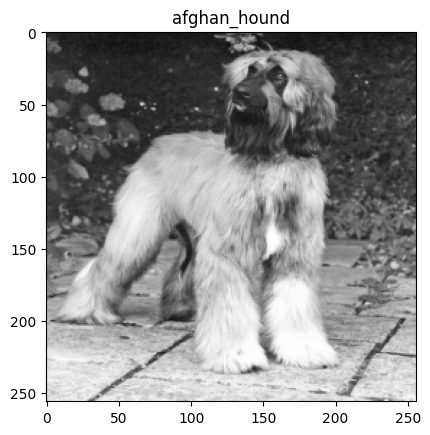

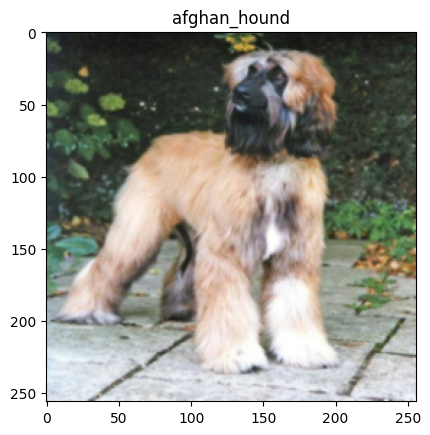

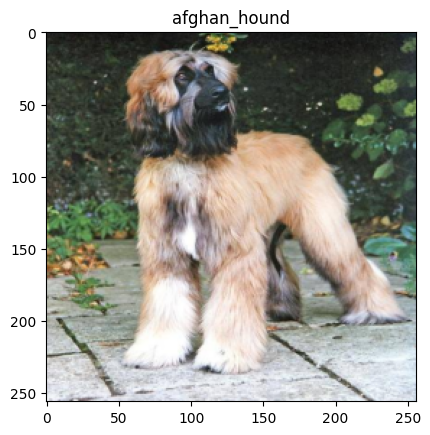

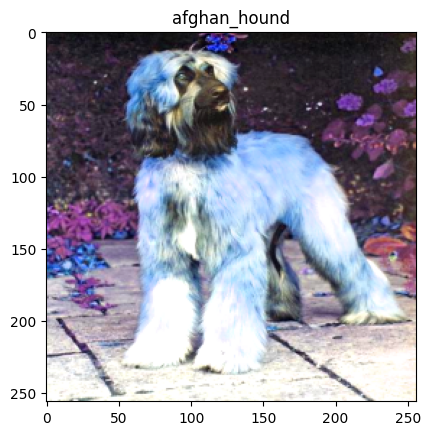

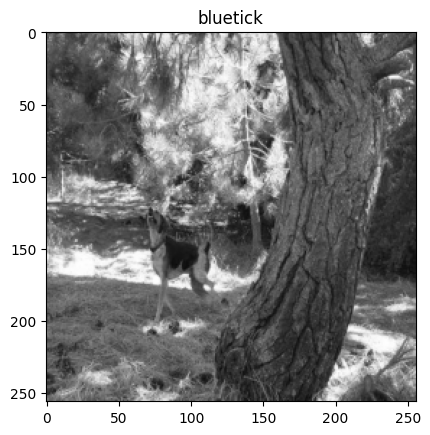

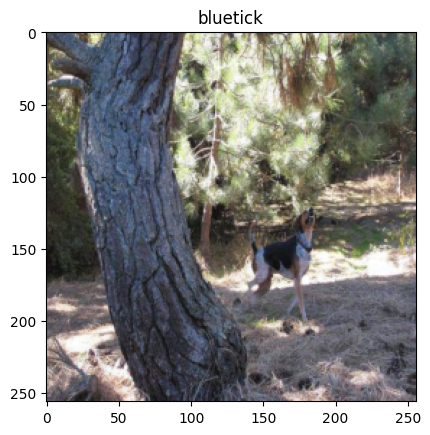

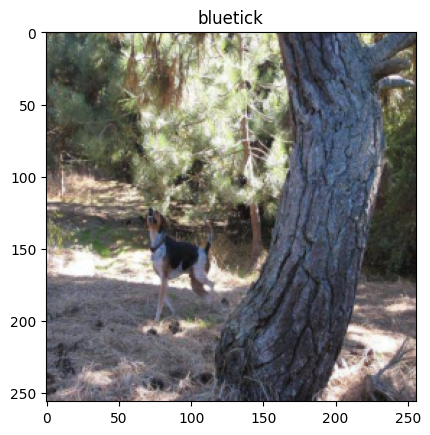

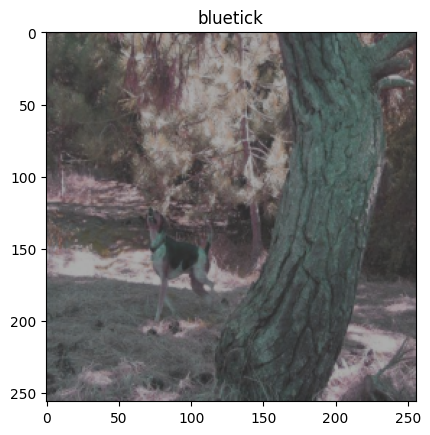

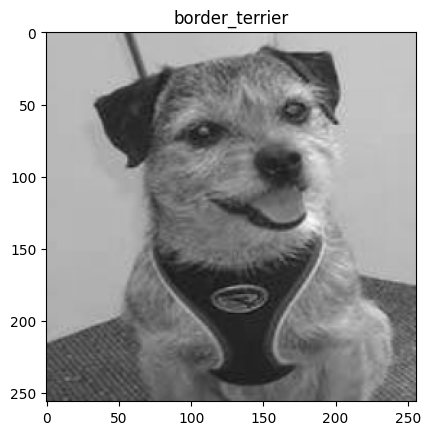

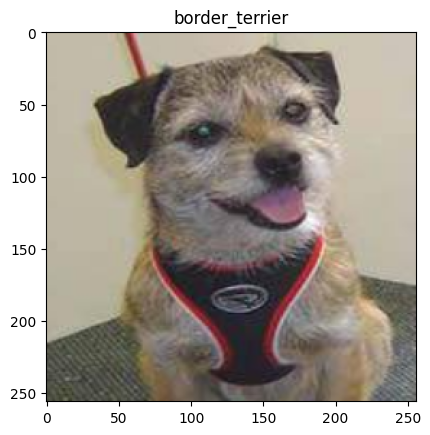

In [18]:
for i in range(10): 
    image, label = aug_train_dataset[i]
    plt.imshow(image.permute(1, 2, 0).int())
    plt.title(breeds[label])
    plt.show()

In [19]:
class CustomModel(nn.Module):
    def __init__(self, num_classes = 120):
        super(CustomModel, self).__init__()
        self.model = models.mobilenet_v3_large(weights="MobileNet_V3_Large_Weights.IMAGENET1K_V1")
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier[-1] = nn.Linear(1280, num_classes)
        
    def forward(self, x):
        return self.model(x)
    
model = CustomModel().to(device)



In [20]:
torchsummary.summary(model, (3, img_height, img_width))

Layer (type:depth-idx)                        Output Shape              Param #
├─MobileNetV3: 1-1                            [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 960, 8, 8]           --
|    |    └─Conv2dNormActivation: 3-1         [-1, 16, 128, 128]        (464)
|    |    └─InvertedResidual: 3-2             [-1, 16, 128, 128]        (464)
|    |    └─InvertedResidual: 3-3             [-1, 24, 64, 64]          (3,440)
|    |    └─InvertedResidual: 3-4             [-1, 24, 64, 64]          (4,440)
|    |    └─InvertedResidual: 3-5             [-1, 40, 32, 32]          (10,328)
|    |    └─InvertedResidual: 3-6             [-1, 40, 32, 32]          (20,992)
|    |    └─InvertedResidual: 3-7             [-1, 40, 32, 32]          (20,992)
|    |    └─InvertedResidual: 3-8             [-1, 80, 16, 16]          (32,080)
|    |    └─InvertedResidual: 3-9             [-1, 80, 16, 16]          (34,760)
|    |    └─InvertedResidual: 3-10            [-1

Layer (type:depth-idx)                        Output Shape              Param #
├─MobileNetV3: 1-1                            [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 960, 8, 8]           --
|    |    └─Conv2dNormActivation: 3-1         [-1, 16, 128, 128]        (464)
|    |    └─InvertedResidual: 3-2             [-1, 16, 128, 128]        (464)
|    |    └─InvertedResidual: 3-3             [-1, 24, 64, 64]          (3,440)
|    |    └─InvertedResidual: 3-4             [-1, 24, 64, 64]          (4,440)
|    |    └─InvertedResidual: 3-5             [-1, 40, 32, 32]          (10,328)
|    |    └─InvertedResidual: 3-6             [-1, 40, 32, 32]          (20,992)
|    |    └─InvertedResidual: 3-7             [-1, 40, 32, 32]          (20,992)
|    |    └─InvertedResidual: 3-8             [-1, 80, 16, 16]          (32,080)
|    |    └─InvertedResidual: 3-9             [-1, 80, 16, 16]          (34,760)
|    |    └─InvertedResidual: 3-10            [-1

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [22]:
len(train_dataset), len(test_dataset)

(9710, 512)

In [23]:
len(aug_train_dataset)

38840

In [24]:
train_loader = DataLoader(dataset=aug_train_dataset, batch_size=150, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=150, shuffle=True, pin_memory=True)

In [29]:
n_epochs = 1

for epoch in range(n_epochs):
    model.train()
    correct = 0 
    running_loss = 0
    total = 0 
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration: {i}, Loss: {running_loss / (i + 1)}, Accuracy: {correct / total}")
    print(f"Epoch: {epoch}, Loss: {running_loss / len(train_loader)}, Accuracy: {correct / total}")
    with torch.no_grad():
        correct = 0 
        total = 0 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Test Accuracy: {correct / total}")



Epoch 0, Iteration: 0, Loss: 0.5926210880279541, Accuracy: 0.86
Epoch 0, Iteration: 10, Loss: 0.5620740245689045, Accuracy: 0.8957575757575758
Epoch 0, Iteration: 20, Loss: 0.5798807172548204, Accuracy: 0.8911111111111111
Epoch 0, Iteration: 30, Loss: 0.5795557393181708, Accuracy: 0.8858064516129033
Epoch 0, Iteration: 40, Loss: 0.5947130533253274, Accuracy: 0.8808130081300813
Epoch 0, Iteration: 50, Loss: 0.6011519052234351, Accuracy: 0.8777777777777778
Epoch 0, Iteration: 60, Loss: 0.6040446616587092, Accuracy: 0.8760655737704918
Epoch 0, Iteration: 70, Loss: 0.6067981178491888, Accuracy: 0.8741784037558685
Epoch 0, Iteration: 80, Loss: 0.6079618441469875, Accuracy: 0.8730864197530864
Epoch 0, Iteration: 90, Loss: 0.6073582264093252, Accuracy: 0.8728937728937729
Epoch 0, Iteration: 100, Loss: 0.6060526854921096, Accuracy: 0.8726732673267327
Epoch 0, Iteration: 110, Loss: 0.6073964353617247, Accuracy: 0.8723123123123123
Epoch 0, Iteration: 120, Loss: 0.6068467830330873, Accuracy: 0.87

In [31]:
model.eval()
with torch.no_grad():
    correct = 0 
    total = 0 
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.float()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {correct / total}")

# torch.save(model.state_dict(), "moble_net.pth")


Test Accuracy: 0.9360968074150361


In [6]:
class Tuned_EfficientNet(nn.Module):
    def __init__(self, num_classes=120):
        super(Tuned_EfficientNet, self).__init__()
        self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier[-1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.model(x)
    
ef_model = Tuned_EfficientNet().to(device)

torchsummary.summary(ef_model, (3, img_height, img_width))

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 1280, 8, 8]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 24, 128, 128]        (696)
|    |    └─Sequential: 3-2                   [-1, 24, 128, 128]        (10,464)
|    |    └─Sequential: 3-3                   [-1, 48, 64, 64]          (303,552)
|    |    └─Sequential: 3-4                   [-1, 64, 32, 32]          (589,184)
|    |    └─Sequential: 3-5                   [-1, 128, 16, 16]         (917,680)
|    |    └─Sequential: 3-6                   [-1, 160, 16, 16]         (3,463,840)
|    |    └─Sequential: 3-7                   [-1, 256, 8, 8]           (14,561,832)
|    |    └─Conv2dNormActivation: 3-8         [-1, 1280, 8, 8]          (330,240)
|    └─AdaptiveAvgPool2d: 2-2                 [-1, 1280, 1, 1]          --
|    └─Sequential: 2-3                 

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 1280, 8, 8]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 24, 128, 128]        (696)
|    |    └─Sequential: 3-2                   [-1, 24, 128, 128]        (10,464)
|    |    └─Sequential: 3-3                   [-1, 48, 64, 64]          (303,552)
|    |    └─Sequential: 3-4                   [-1, 64, 32, 32]          (589,184)
|    |    └─Sequential: 3-5                   [-1, 128, 16, 16]         (917,680)
|    |    └─Sequential: 3-6                   [-1, 160, 16, 16]         (3,463,840)
|    |    └─Sequential: 3-7                   [-1, 256, 8, 8]           (14,561,832)
|    |    └─Conv2dNormActivation: 3-8         [-1, 1280, 8, 8]          (330,240)
|    └─AdaptiveAvgPool2d: 2-2                 [-1, 1280, 1, 1]          --
|    └─Sequential: 2-3                 

In [47]:
train_loader = DataLoader(dataset=aug_train_dataset, batch_size=45, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=45, shuffle=False, pin_memory=True)

In [48]:

criterion = nn.CrossEntropyLoss()
optimizer = Adam(ef_model.parameters(), lr=0.0005)


In [49]:
n_epochs = 2

for epoch in range(n_epochs):
    correct = 0 
    running_loss = 0
    total = 0
    ef_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.float()
        optimizer.zero_grad()
        outputs = ef_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 10 == 0:
            print(f"Epoch {epoch}, Batch: {i}, Loss: {running_loss / (i + 1)}, Accuracy: {correct * 100 / total}%")
    print(f"Epoch: {epoch}, Loss: {running_loss / len(train_loader)}, Accuracy: {correct * 100 / total}%")

    ef_model.eval()
    with torch.no_grad():
        correct = 0 
        total = 0 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            outputs = ef_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Test Accuracy: {correct * 100 / total}%")


# save the model
torch.save(ef_model.state_dict(), "efficient_net_ep4.pth")


Epoch 0, Batch: 0, Loss: 0.5714593529701233, Accuracy: 93.33333333333333%
Epoch 0, Batch: 10, Loss: 0.7569668997417797, Accuracy: 80.0%
Epoch 0, Batch: 20, Loss: 0.7344378601937067, Accuracy: 79.57671957671958%
Epoch 0, Batch: 30, Loss: 0.7039461866501839, Accuracy: 80.28673835125448%
Epoch 0, Batch: 40, Loss: 0.690614930013331, Accuracy: 80.75880758807588%
Epoch 0, Batch: 50, Loss: 0.6635125817037096, Accuracy: 81.74291938997821%
Epoch 0, Batch: 60, Loss: 0.6611797423636327, Accuracy: 81.74863387978142%
Epoch 0, Batch: 70, Loss: 0.6707764431624346, Accuracy: 81.15805946791862%
Epoch 0, Batch: 80, Loss: 0.6790467651537907, Accuracy: 80.79561042524006%
Epoch 0, Batch: 90, Loss: 0.6653205637748425, Accuracy: 81.17216117216117%
Epoch 0, Batch: 100, Loss: 0.6626604010563085, Accuracy: 81.27612761276127%
Epoch 0, Batch: 110, Loss: 0.6574204741297541, Accuracy: 81.16116116116116%
Epoch 0, Batch: 120, Loss: 0.6532422134206315, Accuracy: 81.35904499540864%
Epoch 0, Batch: 130, Loss: 0.65055345

In [50]:
def top_3_accuracy(outputs, labels):
    _, predicted = torch.topk(outputs, 3, 1)
    correct = 0 
    for i in range(len(labels)):
        if labels[i] in predicted[i]:
            correct += 1
    return correct

ef_model.eval()
with torch.no_grad():
    correct = 0 
    total = 0 
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.float()
        outputs = ef_model(images)
        total += labels.size(0)
        correct += top_3_accuracy(outputs, labels)
    print(f"Test Accuracy: {correct * 100 / total}%")

Test Accuracy: 96.484375%


In [51]:
n_epochs = 2

for epoch in range(n_epochs):
    correct = 0 
    running_loss = 0
    total = 0
    ef_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.float()
        optimizer.zero_grad()
        outputs = ef_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 10 == 0:
            print(f"Epoch {epoch}, Batch: {i}, Loss: {running_loss / (i + 1)}, Accuracy: {correct * 100 / total}%")
    print(f"Epoch: {epoch}, Loss: {running_loss / len(train_loader)}, Accuracy: {correct * 100 / total}%")

    ef_model.eval()
    with torch.no_grad():
        correct = 0 
        total = 0 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            outputs = ef_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Test Accuracy: {correct * 100 / total}%")


# save the model
torch.save(ef_model.state_dict(), "efficient_net_ep6.pth")


Epoch 0, Batch: 0, Loss: 0.3692689538002014, Accuracy: 93.33333333333333%
Epoch 0, Batch: 10, Loss: 0.5125438543883237, Accuracy: 84.24242424242425%
Epoch 0, Batch: 20, Loss: 0.532430519660314, Accuracy: 84.02116402116403%
Epoch 0, Batch: 30, Loss: 0.5423502883603496, Accuracy: 83.94265232974911%
Epoch 0, Batch: 40, Loss: 0.5390862095646742, Accuracy: 84.49864498644986%
Epoch 0, Batch: 50, Loss: 0.5498740819155001, Accuracy: 84.05228758169935%
Epoch 0, Batch: 60, Loss: 0.5382983748052941, Accuracy: 84.15300546448087%
Epoch 0, Batch: 70, Loss: 0.5304037628459258, Accuracy: 84.4131455399061%
Epoch 0, Batch: 80, Loss: 0.5296310107281179, Accuracy: 84.19753086419753%
Epoch 0, Batch: 90, Loss: 0.5250799028755544, Accuracy: 84.46886446886447%
Epoch 0, Batch: 100, Loss: 0.5248834381599238, Accuracy: 84.57645764576458%
Epoch 0, Batch: 110, Loss: 0.5252778806664922, Accuracy: 84.64464464464464%
Epoch 0, Batch: 120, Loss: 0.5298269492042952, Accuracy: 84.44444444444444%
Epoch 0, Batch: 130, Loss

In [7]:
app_model = Tuned_EfficientNet().to(device)

app_model.load_state_dict(torch.load("efficient_net_ep4.pth"))

torchsummary.summary(app_model, (3, img_height, img_width))

C:\Users\yinch\AppData\Local\Temp\ipykernel_28600\3812018488.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  app_model.load_state_dict(torch.load("efficient_net_ep4.pth"

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 1280, 8, 8]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 24, 128, 128]        (696)
|    |    └─Sequential: 3-2                   [-1, 24, 128, 128]        (10,464)
|    |    └─Sequential: 3-3                   [-1, 48, 64, 64]          (303,552)
|    |    └─Sequential: 3-4                   [-1, 64, 32, 32]          (589,184)
|    |    └─Sequential: 3-5                   [-1, 128, 16, 16]         (917,680)
|    |    └─Sequential: 3-6                   [-1, 160, 16, 16]         (3,463,840)
|    |    └─Sequential: 3-7                   [-1, 256, 8, 8]           (14,561,832)
|    |    └─Conv2dNormActivation: 3-8         [-1, 1280, 8, 8]          (330,240)
|    └─AdaptiveAvgPool2d: 2-2                 [-1, 1280, 1, 1]          --
|    └─Sequential: 2-3                 

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNet: 1-1                           [-1, 120]                 --
|    └─Sequential: 2-1                        [-1, 1280, 8, 8]          --
|    |    └─Conv2dNormActivation: 3-1         [-1, 24, 128, 128]        (696)
|    |    └─Sequential: 3-2                   [-1, 24, 128, 128]        (10,464)
|    |    └─Sequential: 3-3                   [-1, 48, 64, 64]          (303,552)
|    |    └─Sequential: 3-4                   [-1, 64, 32, 32]          (589,184)
|    |    └─Sequential: 3-5                   [-1, 128, 16, 16]         (917,680)
|    |    └─Sequential: 3-6                   [-1, 160, 16, 16]         (3,463,840)
|    |    └─Sequential: 3-7                   [-1, 256, 8, 8]           (14,561,832)
|    |    └─Conv2dNormActivation: 3-8         [-1, 1280, 8, 8]          (330,240)
|    └─AdaptiveAvgPool2d: 2-2                 [-1, 1280, 1, 1]          --
|    └─Sequential: 2-3                 

In [55]:
img = read_image("./data/custom_data/poodle.jpg")
img = T.Resize((img_height, img_width))(img)
img = img.to(device)
img = img.unsqueeze(0)

app_model.eval()

with torch.no_grad():
    ouput = app_model(img.float()).to(device)


print(ouput)


tensor([[-3.2848, -3.3280, -5.7595, -3.3184, -2.5034, -0.6204, -3.3922, -3.3037,
         -2.9817, -3.1117, -2.4998, -2.1879, -5.2586, -1.6331, -2.7079, -4.2831,
         -3.8974, -4.6095, -4.4999, -2.8753, -6.3768,  0.6085, -2.6375, -4.2191,
         -3.2100, -3.8614, -4.5123, -2.0750, -2.4961, -3.5943, -2.9696, -3.8828,
         -0.7763, -5.7355, -2.9273, -4.3738, -3.3252, -3.8258, -0.4328, -4.1007,
         -3.9168, -3.8755, -6.3697, -5.7008, -4.1347, -2.8836, -4.5140, -4.2411,
         -1.1763, -4.9121, -2.8600, -4.1230, -3.7737, -4.1748, -3.9532, -4.0898,
         -4.9869, -2.7236, -3.1520, -1.9290, -3.4536, -3.7361, -0.0897, -2.5078,
         -4.3900, -3.2439, -4.2054, -3.3449, -2.7729, -2.7073, -4.9027, -3.8884,
         -1.3905, -4.2551, -1.4874, -0.3843, -4.1134, -4.1584, -1.2244, -3.1615,
         -6.1506, -4.3010, -3.5098, -1.9592, -5.4609, -1.1050, -3.6853, -2.5731,
         -2.8054, -5.3084, -3.7746, -3.9954, -4.7126, -1.9771, -0.9619, -4.4772,
         -2.9740, -3.7247, -

In [58]:
# apply softmax
output = F.softmax(ouput, dim=1)
output

tensor([[4.8946e-05, 4.6877e-05, 4.1209e-06, 4.7328e-05, 1.0693e-04, 7.0285e-04,
         4.3964e-05, 4.8030e-05, 6.6275e-05, 5.8199e-05, 1.0732e-04, 1.4660e-04,
         6.7999e-06, 2.5529e-04, 8.7151e-05, 1.8037e-05, 2.6525e-05, 1.3014e-05,
         1.4522e-05, 7.3718e-05, 2.2227e-06, 2.4019e-03, 9.3504e-05, 1.9230e-05,
         5.2748e-05, 2.7499e-05, 1.4343e-05, 1.6411e-04, 1.0771e-04, 3.5918e-05,
         6.7084e-05, 2.6917e-05, 6.0137e-04, 4.2207e-06, 6.9984e-05, 1.6473e-05,
         4.7011e-05, 2.8494e-05, 8.4793e-04, 2.1647e-05, 2.6016e-05, 2.7114e-05,
         2.2386e-06, 4.3699e-06, 2.0924e-05, 7.3107e-05, 1.4318e-05, 1.8811e-05,
         4.0313e-04, 9.6159e-06, 7.4856e-05, 2.1169e-05, 3.0019e-05, 2.0100e-05,
         2.5087e-05, 2.1883e-05, 8.9234e-06, 8.5796e-05, 5.5899e-05, 1.8991e-04,
         4.1345e-05, 3.1169e-05, 1.1949e-03, 1.0646e-04, 1.6209e-05, 5.0991e-05,
         1.9496e-05, 4.6092e-05, 8.1665e-05, 8.7204e-05, 9.7067e-06, 2.6765e-05,
         3.2540e-04, 1.8549e

In [59]:
# get top 3
_, predicted = torch.topk(output, 3, 1)
predicted

tensor([[101, 104,  21]], device='cuda:0')

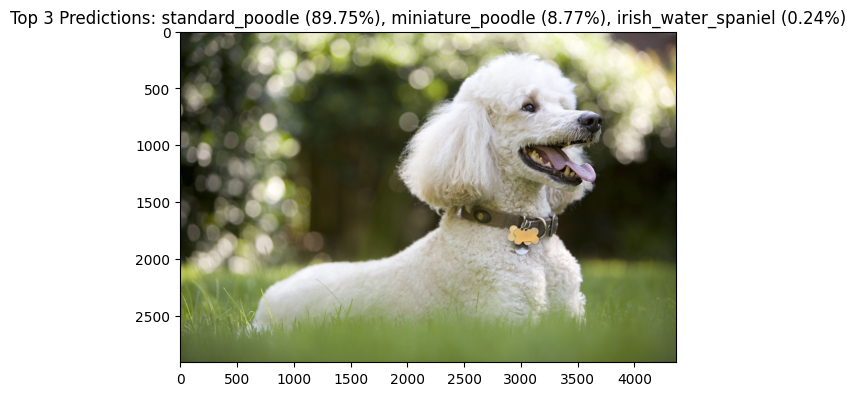

In [64]:
# plot the image with top 3 predictions + percentage

# use label instead of title in plot 
plt.imshow(read_image("./data/custom_data/poodle.jpg").permute(1, 2, 0))
# text in legend top 3 
plt.title(f"Top 3 Predictions: {breeds[predicted[0][0]]} ({output[0][predicted[0][0]] * 100:.2f}%), {breeds[predicted[0][1]]} ({output[0][predicted[0][1]] * 100:.2f}%), {breeds[predicted[0][2]]} ({output[0][predicted[0][2]] * 100:.2f}%)")
plt.show()

In [40]:
def predict_image(image_path):
    img = read_image(image_path)
    # if 4 channels, remove the alpha channel
    if img.size(0) == 4:
        img = img[:3]
    img = T.Resize((img_height, img_width))(img)
    img = img.to(device)
    img = img.unsqueeze(0)
    app_model.eval()
    with torch.no_grad():
        ouput = app_model(img.float()).to(device)
    output = F.softmax(ouput, dim=1)
    _, predicted = torch.topk(output, 3, 1)
    plt.imshow(read_image(image_path).permute(1, 2, 0))
    plt.title(f"Top 3 Predictions: {breeds[predicted[0][0]]} ({output[0][predicted[0][0]] * 100:.2f}%), {breeds[predicted[0][1]]} ({output[0][predicted[0][1]] * 100:.2f}%), {breeds[predicted[0][2]]} ({output[0][predicted[0][2]] * 100:.2f}%)")
    plt.show()

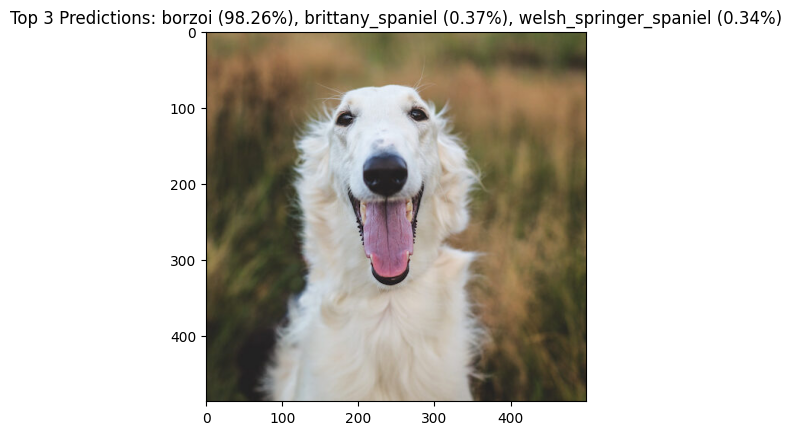

In [11]:
predict_image("D:\Downloads\Borzoi-head-portrait-outdoors-500x486.jpeg")

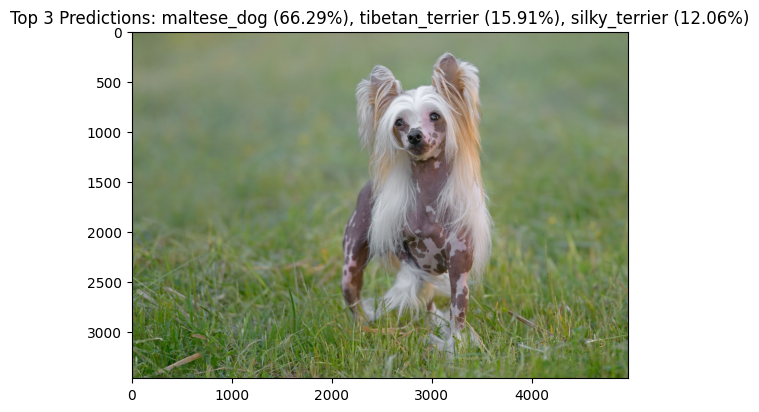

In [80]:
predict_image("D:\Downloads\crested.jpg")

In [81]:
breeds

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

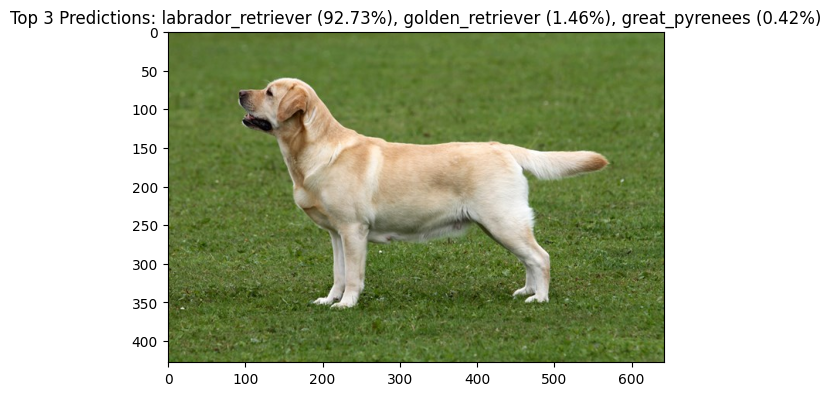

In [83]:
predict_image("D:\Downloads\\ret.jpg")

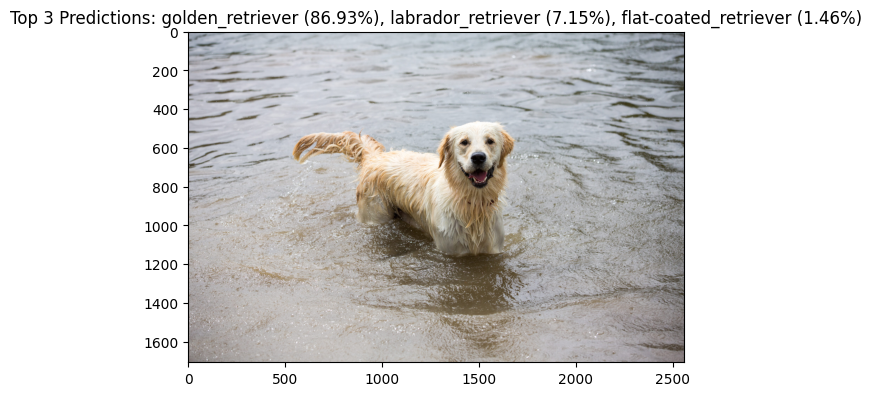

In [12]:
import requests
import uuid


def predict_url(url):
    response = requests.get(url)
    # save to file at dir "./data/custom_data"
    path = f"./data/custom_data/{uuid.uuid4()}.jpg"
    with open(path, "wb") as f:
        f.write(response.content)
    img = read_image(path)
    img = T.Resize((img_height, img_width))(img)
    img = img.float()
    img = img.to(device)
    img = img.unsqueeze(0)
    app_model.eval()
    with torch.no_grad():
        ouput = app_model(img.float()).to(device)
    output = F.softmax(ouput, dim=1)
    _, predicted = torch.topk(output, 3, 1)
    plt.imshow(read_image(path).permute(1, 2, 0))
    plt.title(f"Top 3 Predictions: {breeds[predicted[0][0]]} ({output[0][predicted[0][0]] * 100:.2f}%), {breeds[predicted[0][1]]} ({output[0][predicted[0][1]] * 100:.2f}%), {breeds[predicted[0][2]]} ({output[0][predicted[0][2]] * 100:.2f}%)")
    plt.show()


predict_url("https://www.mybestfrienddogcare.co.uk/wp-content/uploads/2020/09/My-Best-Friend-144-scaled.jpg")

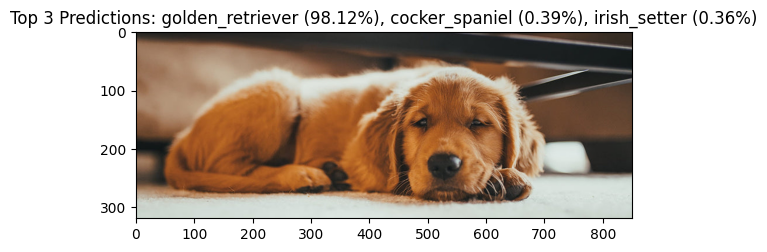

In [92]:
predict_url("https://www.lordsandlabradors.co.uk/cdn/shop/articles/golden_retriever_banner.jpg?crop=center&height=600&v=1616664256&width=1000")

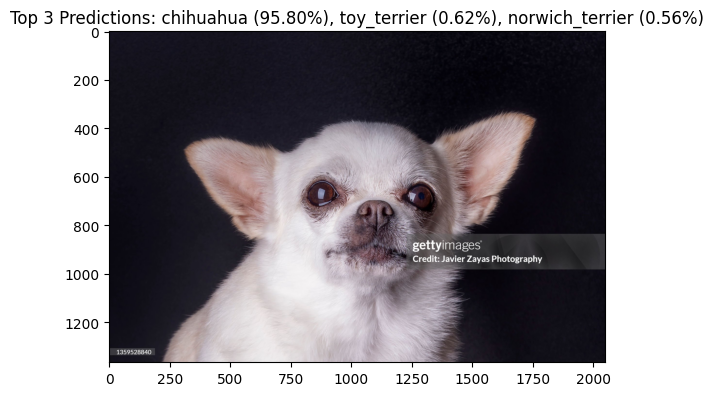

In [17]:
url = "https://media.gettyimages.com/id/1359528840/photo/chihuahua-dog-portrait.jpg?s=2048x2048&w=gi&k=20&c=5wDjcv87_DxxhVtgm7uc0HBlb1_-RNrGLc_SuUCWec4="

predict_url(url)

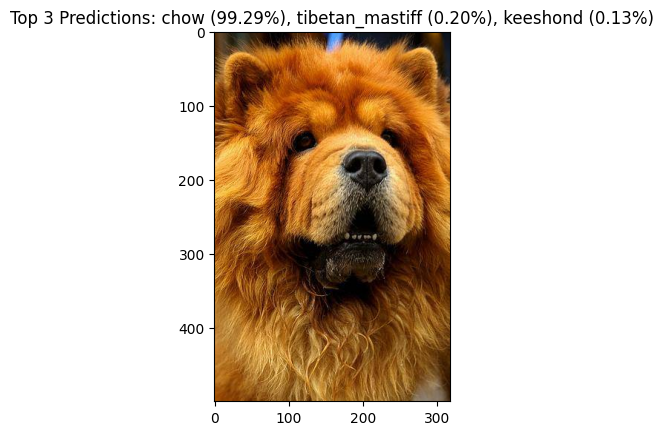

In [24]:
predict_image(r"C:\Users\yinch\Documents\Machine-Learning\Dog Breeds\data\test\1a9721dd4a7f07d1fcd55d03271f9a6e.jpg")

In [32]:
path = r"C:\Users\yinch\Documents\Machine-Learning\Dog Breeds\data\test\2c4fdb0f1d0545356e20bf11b166a98b.jpg"

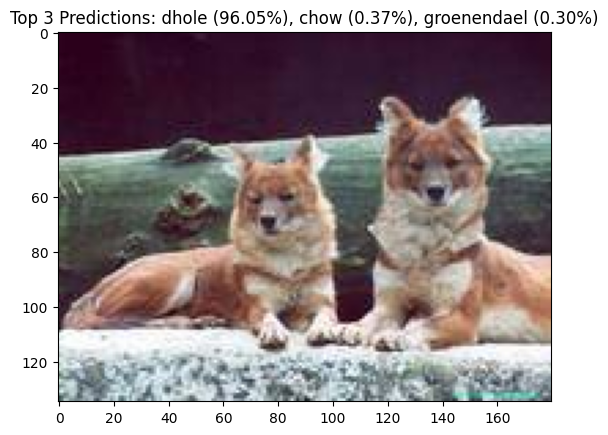

In [33]:
predict_image(path)

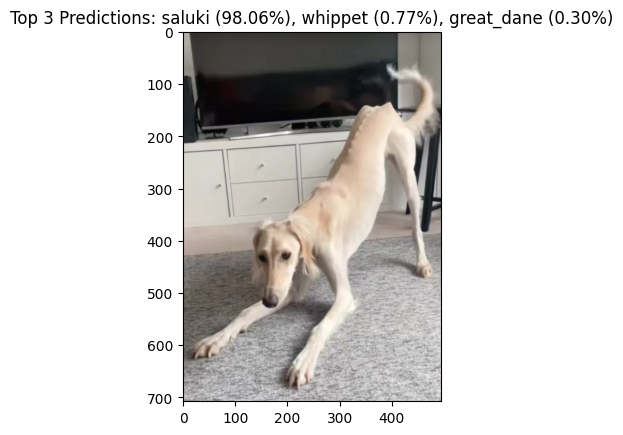

In [50]:
predict_image(r"C:\Users\yinch\Pictures\Screenshots\Screenshot 2024-09-14 141241.png")

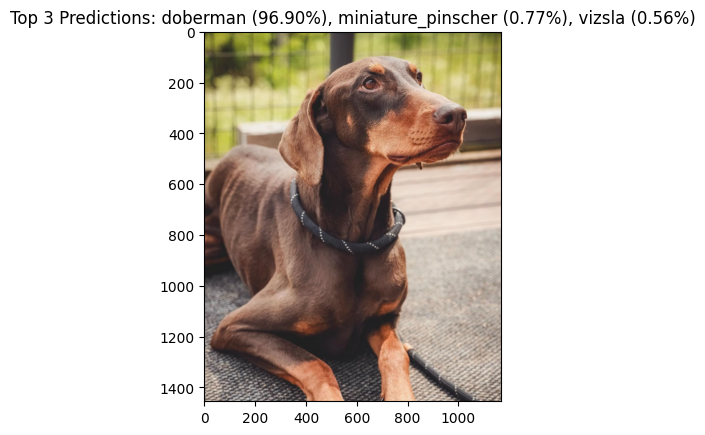

In [51]:
predict_image(r"D:\Downloads\2024-09-14 02.26.00.png")